In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import butter,filtfilt
from scipy.optimize import fsolve
from scipy.integrate import odeint
from scipy import linalg
import scipy.constants as cst

In [44]:
class dispersion_in_JJ_metamaterial:

	def __init__(self):

		self.version = '0.1.1'

		self.pump_frequency = None				# in GHz
		self.incident_pump_amplitude = None		
		self.phi_ext = np.pi 					# external magnetic flux in the loop		

		self.loss_tangent = None				# loss tangent
		self.number_of_loops = None				# number of loops in the transmission line
		self.size_of_one_loop = None			# size of one SNAIL loop in m
		self.I0 = None							# critical current of large junction
		self.I0_ratio = None					# ratio of critical currents in the SNAIL
		self.C_g = None							# ground capacitance
		self.C_J = None							# junction capacitance

		self.gamma = None						# kerr nonlinearity
		self.L_loop = None						# loop inductance

		self.phi_0 = 2e-15



	def linear_to_dB(self,linear):

		return 10*(np.log10(linear))


	def I(self,phi_s):

		return self.I0_ratio*self.I0*np.sin(phi_s)+self.I0*np.sin((phi_s-self.phi_ext)/3.0)


	def calculate_loop_parameters(self):

		phi_smin = fsolve(self.I, 0)
		gamma_tilde = (1.0/6)*(self.I0_ratio*np.cos(phi_smin)+(1.0/27)*np.cos((phi_smin-self.phi_ext)/3.0))
		alpha_tilde = self.I0_ratio*np.cos(phi_smin)+(1.0/3)*np.cos((phi_smin-self.phi_ext)/3.0)
		self.gamma = gamma_tilde/alpha_tilde
		self.L_loop = abs(1.0*self.phi_0/(alpha_tilde*self.I0*2*np.pi))


	def phase_mismatch(self,w_s):

		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		gamma = self.gamma
		L_loop = self.L_loop
		C_g = self.C_g
		C_J = self.C_J

		w_p = pump_frequency*1e9*2*np.pi
		w_i = 2*w_p-w_s
		w_0 = 1.0/(np.sqrt(L_loop*C_g))
		w_J = 1.0/(np.sqrt(L_loop*C_J))
		k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
		k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
		k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
		w_til_p = 1-(w_p/w_J)**2
		w_til_s = 1-(w_s/w_J)**2
		w_til_i = 1-(w_i/w_J)**2
		k_p_loss = loss_tangent*k_p/2
		pump_amplitude_reduced = pump_amplitude*np.exp(-k_p_loss*self.number_of_loops/2)
		eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
		eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
		eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
		del_k_disp = 2*k_p-k_i-k_s
		del_kerr = 2*eta_p-eta_i-eta_s
		del_k_total = del_k_disp + del_kerr
		return del_k_disp, del_kerr, del_k_total


	def phase_mismatch_vs_frequency(self,freq_array):
		
		del_k_disp_array = np.array([])
		del_k_kerr_array = np.array([])
		del_k_total_array = np.array([])

		for freq in freq_array:

			del_k_disp, del_kerr, del_k_total = self.phase_mismatch(freq*1e9*2*np.pi)
			del_k_disp_array = np.append(del_k_disp_array,del_k_disp)
			del_k_kerr_array = np.append(del_k_kerr_array,del_kerr)
			del_k_total_array = np.append(del_k_total_array,del_k_total)

		return del_k_disp_array/self.size_of_one_loop, del_k_kerr_array/self.size_of_one_loop, del_k_total_array/self.size_of_one_loop


	def gain(self,w_s):

		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		gamma = self.gamma
		L_loop = self.L_loop
		C_g = self.C_g
		C_J = self.C_J
		number_of_loops = self.number_of_loops

		w_p = pump_frequency*1e9*2*np.pi
		w_i = 2*w_p-w_s
		w_0 = 1.0/(np.sqrt(L_loop*C_g))
		w_J = 1.0/(np.sqrt(L_loop*C_J))
		k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
		k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
		k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
		w_til_p = 1-(w_p/w_J)**2
		w_til_s = 1-(w_s/w_J)**2
		w_til_i = 1-(w_i/w_J)**2
		k_p_loss = loss_tangent*k_p/2
		pump_amplitude_reduced = pump_amplitude*np.exp(-k_p_loss*number_of_loops/2)
		eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
		eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
		eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
		del_k_disp = 2*k_p-k_i-k_s
		del_kerr = 2*eta_p-eta_i-eta_s
		del_k_total = del_k_disp + del_kerr

		k_i_loss = loss_tangent*k_i/2
		k_s_loss = loss_tangent*k_s/2
		Phi11 = -1j*0.5*del_k_total-k_s_loss
		Phi12 = 1j*eta_s*k_i/(k_s*2)
		Phi21 = -1j*eta_i*k_s/(k_i*2)
		Phi22 = 1j*0.5*del_k_total-k_i_loss
		matrix_Phi = np.array([[Phi11,Phi12],[Phi21,Phi22]])
		exp_Phi = linalg.expm(matrix_Phi*number_of_loops)
		gain_lin = abs(exp_Phi[0][0])**2

		return self.linear_to_dB(gain_lin)


	def gain_vs_freq(self,freq_array):
		
		gain_array = np.array([])

		for freq_s in freq_array:

			w_s = freq_s*1e9*2*np.pi
			gain_array = np.append(gain_array,self.gain(w_s))

		return gain_array

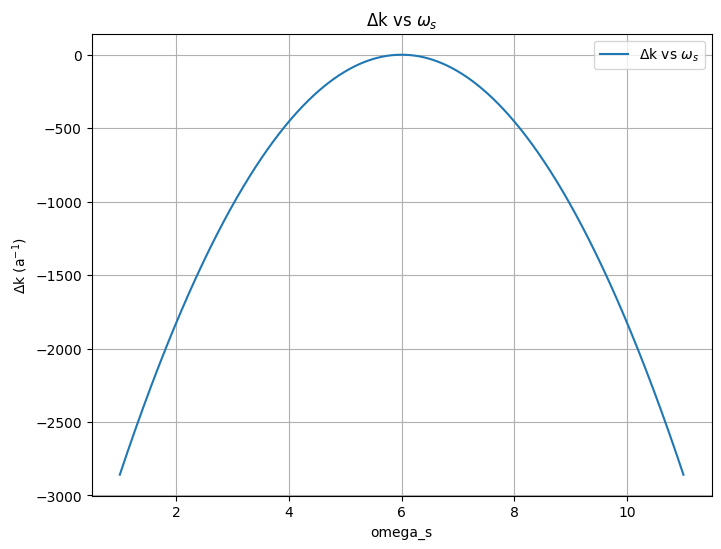

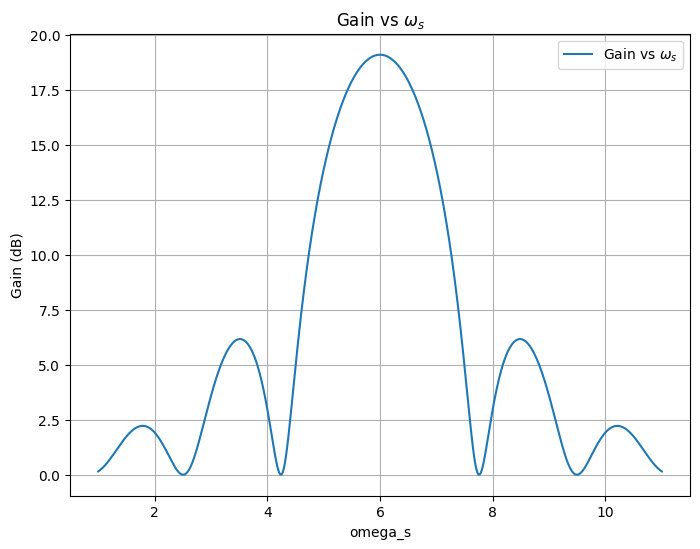

In [45]:
sim = dispersion_in_JJ_metamaterial()

sim.pump_frequency = 6				# in GHz
sim.incident_pump_amplitude = 1		
sim.phi_ext = np.pi					# external magnetic flux in the loop		

sim.loss_tangent = 1e-6				# loss tangent
sim.number_of_loops = 700				# number of loops in the transmission line
sim.size_of_one_loop = 1e-6			# size of one SNAIL loop in m
sim.I0 = 2.19e-6							# critical current of large junction
sim.I0_ratio = 0.07					# ratio of critical currents in the SNAIL
sim.C_g = 250e-15							# ground capacitance
sim.C_J = 50e-15							# junction capacitance

sim.gamma = 5			# kerr nonlinearity
sim.L_loop = 100e-12


omega_s_range = np.linspace(1, 11, 1000)
dk_values = sim.phase_mismatch_vs_frequency(omega_s_range)[0]
gain_values = sim.gain_vs_freq(omega_s_range)


plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, dk_values, label=r'$\Delta$k vs $\omega_s$')
plt.xlabel('omega_s')
plt.ylabel(r'$\Delta$k (a$^{-1}$)')
plt.title(r'$\Delta$k vs $\omega_s$')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, gain_values, label=r'Gain vs $\omega_s$')
plt.xlabel('omega_s')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_s$')
plt.grid(True)
plt.legend()
plt.show()